# README Prophesy
By Nicole Garza & Michael P. Moran

  ## Table of contents
1. [Project Planning](#project-planning)
1. [Acquisition](#acquisition)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)

## Project Planning <a name="project-planning"></a>

### Goals

A model that predicts the predominant language of a GitHub repo given the repo's README file

### Deliverables

* Jupyter notebook containing analysis
* One or two google slides suitable for a general audience that summarize findings. Include a well-labelled visualization in your slides.
* A function taking a README as input and outputting the language

### Project Conclusions

* Acquisition
    * Acquiring the data was challenging. We had two main options: (1) scrape the HTML-rendered search results and (2) use the JSON API. We chose to use the JSON API because it allowed dictionary-based access to the information we needed. We did not have to identify the correct HTML tag or do anything else associated with scraping. The JSON API also allowed us to download many more repos faster than scraping the HTML.
    * We also had the choice of scraping the HTML rendered README or downloading the raw README file. Acquiring the raw README was significantly easier, so we chose this. However, GitHub's API only returns a raw README file, not the rendered HTML version (although it's available in a link).
* Preparation
    * We processed the raw README using a markdown module, which rendered it to HTML. We then used Beautiful Soup to extract the text. We removed single character words (which was pointless because the sklearn vectorizers do this already) and also removed links.
    * We also removed non-English repos given that we are ASCII normalizing. Thus, our model is for English repos only. We dropped repos with no programming language, so our model has this limitation.
* Exploration
    * The most common languages were JavaScript, Java, Python, C++, and HTML. JavaScript and Java are heavily overrepresented. If we had more time, we would have rebalanced the dataset, so they do not predominate.
    * The most common words look like generic programming terms ("use", "code", "file") and do not appear to be useful indicators of the language (except for JavaScript, which we hope would indicate JavaScript). Also, there is significant overlap of the most common bigrams for the languages. Thus, bigrams may not perform better than single words.
    * We have problems with runon words. If we had more time, this is something to address.
* Modeling
    * Our model predicts for only the top 5 most common repos. Thus, an input repo that is not predominately programmed in one of these languages will automatically be wrong. We tried to use an "other" category but this sorely hurt our models' performance. Accuracy plummeted about 20-30 percentage points on average. It may be because "other" had such diversity of language it was pulling in repos it shouldn't. We tried using bigrams, but these did not give us better predictive power, which was not expected. The bigrams appeared to be unique overall to the individual languages.
    * We also used lemmatized, stemmed, and clean version of the README. Clean appeared to perform on par with stemmed. Not really sure why at this time.
    * With more time, we would add the number of words in the README as a feature.
    * KNN and Random Forest give us our best results

### Data Dictionary & Domain Knowledge

### Hypotheses
* The primary language may be mentioned in the README. But some repositories mention multiple languages, so this may interfere with this method.
* The number of words may be an indication of the language. Older repositories are probably written in certain languages and because of their age, may have more documentation.

### Thoughts & Questions

* The code in many repositories are written in multiple languages. We will go with the most predominant language.
* Take out repos with no programming language
* After taking out the "Other" programming language category, the accuracy of the model shot way up! I believe this category acquired so much language that was used in the top5 repos the models were having difficulty choosing the class.


### Prepare the Environment

In [ ]:
import os
import json
from pprint import pprint
import re
import unicodedata
from functools import reduce, partial
from copy import deepcopy
from markdown import markdown
import pickle

import requests
from bs4 import BeautifulSoup
import pandas as pd

import env

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from langdetect import detect

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Acquisition <a name="acquisition"></a>

**Grab data for 1000 most forked repos on GitHub**

**Constants**

In [2]:
NUM_PER_PAGE = 50
PAGES = 20
API_URL = f"https://api.github.com/search/repositories?q=stars:%3E1&sort=forks&order=desc&per_page={NUM_PER_PAGE}"
HEADERS = {"Authorization": f"token {env.oauth_token}"}
REPO_FILE_NAME = "repos.json"

**Download the data or read from repos.json file**

In [3]:
def github_api_req(page):
    data = requests.get(API_URL + f"&page={page}", headers=HEADERS).json()
    return data["items"]


def readme_url(contents_url):
    # find name of README file and construct a link to the raw text of the readme
    for file in requests.get(contents_url, headers=HEADERS).json():
        if file["name"].lower().startswith("readme"):
            return file["download_url"]


def load_repo_metadata(use_cache=True):
    if use_cache and os.path.exists(REPO_FILE_NAME):
        with open(REPO_FILE_NAME, "r") as f:
            contents = json.load(f)
        return contents
    else:
        response = []
        for num in range(1, PAGES + 1):
            response += github_api_req(num)
        for repo in response:
            # get link to contents of repo
            contents_url = repo["contents_url"][
                :-8
            ]  # remove last 8 characters to get working URL

            rmurl = readme_url(contents_url)

            readme_text = None  # sometimes there is no valid URL to the readme
            if rmurl:
                # download README text
                readme_text = requests.get(rmurl, headers=HEADERS).text

            repo["readme"] = readme_text
        with open(REPO_FILE_NAME, "w") as f:
            json.dump(response, f)
        return response


all_repo_data = load_repo_metadata()

In [4]:
all_repo_data[:3]

[{'id': 14204342,
  'node_id': 'MDEwOlJlcG9zaXRvcnkxNDIwNDM0Mg==',
  'name': 'datasharing',
  'full_name': 'jtleek/datasharing',
  'private': False,
  'owner': {'login': 'jtleek',
   'id': 1571674,
   'node_id': 'MDQ6VXNlcjE1NzE2NzQ=',
   'avatar_url': 'https://avatars2.githubusercontent.com/u/1571674?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/jtleek',
   'html_url': 'https://github.com/jtleek',
   'followers_url': 'https://api.github.com/users/jtleek/followers',
   'following_url': 'https://api.github.com/users/jtleek/following{/other_user}',
   'gists_url': 'https://api.github.com/users/jtleek/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/jtleek/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/jtleek/subscriptions',
   'organizations_url': 'https://api.github.com/users/jtleek/orgs',
   'repos_url': 'https://api.github.com/users/jtleek/repos',
   'events_url': 'https://api.github.com/users/jtleek/events{/privac

## Preparation <a name="preparation"></a>

In [5]:
def all_repo_metadata(api_data):
    return [
        repo_metadata(repo) for repo in api_data if repo["readme"] is not None
    ]


def repo_metadata(api_dict):
    # store the id, username, name of repo
    repo_id = api_dict["id"]
    user_name = api_dict["owner"]["login"]
    repo_name = api_dict["name"]

    # find the predominant programming language
    lang = api_dict["language"]

    # render the markdown to html
    html = markdown(api_dict["readme"])
    # and extract the text from the html
    soup = BeautifulSoup(html, "html.parser")
    readme_text = soup.text

    return dict(
        repo_id=repo_id,
        user_name=user_name,
        repo_name=repo_name,
        lang=lang,
        readme=readme_text,
    )


some_repo_data = all_repo_metadata(all_repo_data)

In [6]:
some_repo_data[:3]

[{'repo_id': 14204342,
  'user_name': 'jtleek',
  'repo_name': 'datasharing',
  'lang': None,
  'readme': 'How to share data with a statistician\nThis is a guide for anyone who needs to share data with a statistician or data scientist. The target audiences I have in mind are:\n\nCollaborators who need statisticians or data scientists to analyze data for them\nStudents or postdocs in various disciplines looking for consulting advice\nJunior statistics students whose job it is to collate/clean/wrangle data sets\n\nThe goals of this guide are to provide some instruction on the best way to share data to avoid the most common pitfalls\nand sources of delay in the transition from data collection to data analysis. The Leek group works with a large\nnumber of collaborators and the number one source of variation in the speed to results is the status of the data\nwhen they arrive at the Leek group. Based on my conversations with other statisticians this is true nearly universally.\nMy strong fee

**Clean, stem, lemmatize, and remove stopwords**

In [7]:
# right to left
def compose(*fns):
    return partial(reduce, lambda x, f: f(x), reversed(fns))


# applies in the order supplied
def pipe(v, *fns):
    return reduce(lambda x, f: f(x), fns, v)


def map_exhaust(func, *iters):
    for args in zip(*iters):
        func(*args)


def normalize_text(text):
    return (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )


def remove_chars(text):
    return re.sub(r"[^A-Za-z0-9 ]", "", re.sub(r"\s", " ", text))


def remove_bogus_words(text):
    no_single_words = re.sub(r"\s.{1}\s", "", text)  # remove single characters
    return re.sub(r"http.{1,}[\s\.]*", "", no_single_words)  # remove links


def basic_clean(text):
    return pipe(text, str.lower, normalize_text, remove_chars)


def tokenize(text):
    tokenizer = ToktokTokenizer()
    return tokenizer.tokenize(text, return_str=True)


def stem(text):
    ps = nltk.porter.PorterStemmer()
    return " ".join([ps.stem(word) for word in text.split()])


def lemmatize(text):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in text.split()]
    return " ".join(lemmas)


def remove_stopwords(text, include=[], exclude=[]):
    stopword_list = stopwords.words("english")

    map_exhaust(stopword_list.remove, exclude)
    map_exhaust(stopword_list.append, include)

    removed = " ".join([w for w in text.split() if w not in stopword_list])

    #     print("Removed", len(text.split()) - len(removed.split()), "words")
    return removed


def prep_readme(repo_data):
    copy = deepcopy(repo_data)

    copy["clean"] = pipe(
        copy["readme"],
        basic_clean,
        tokenize,
        remove_stopwords,
        remove_bogus_words,
    )

    copy["stemmed"] = stem(copy["clean"])

    copy["lemmatized"] = lemmatize(copy["clean"])

    return copy


def prep_readme_data(all_repo_data):
    return [prep_readme(repo) for repo in all_repo_data]


df = pd.DataFrame(prep_readme_data(some_repo_data))

any single j's?

In [8]:
df[df.clean.str.contains(" j ")]

Empty DataFrame
Columns: [clean, lang, lemmatized, readme, repo_id, repo_name, stemmed, user_name]
Index: []

any links?

In [9]:
df[df.clean.str.contains(" http")]

Empty DataFrame
Columns: [clean, lang, lemmatized, readme, repo_id, repo_name, stemmed, user_name]
Index: []

### Summarize Data

In [10]:
df.head()

clean        lang  \
0  share data statistician guide anyone needs sha...        None   
1  introduction second programming assignment req...           R   
2  well hello repository meant provide example fo...        HTML   
3  documentation tensorflow open source software ...         C++   
4  bootstrap sleek intuitive powerful frontend fr...  JavaScript   

                                          lemmatized  \
0  share data statistician guide anyone need shar...   
1  introduction second programming assignment req...   
2  well hello repository meant provide example fo...   
3  documentation tensorflow open source software ...   
4  bootstrap sleek intuitive powerful frontend fr...   

                                              readme   repo_id  \
0  How to share data with a statistician\nThis is...  14204342   
1  Introduction\nThis second programming assignme...  15917132   
2  Well hello there!\nThis repository is meant to...   1300192   
3  \n\n\n\n| Documentation |\n|-----------------|...  45717250   
4  \n\n\n\n\nBootstrap\n\n  Sleek, intuitive, and...   2126244   

                repo_name                                            stemmed  \
0             datasharing  share data statistician guid anyon need share ...   
1  ProgrammingAssignment2  introduct second program assign requir writefu...   
2             Spoon-Knife  well hello repositori meant provid exampl fork...   
3              tensorflow  document tensorflow open sourc softwar librari...   
4               bootstrap  bootstrap sleek intuit power frontend framewor...   

    user_name  
0      jtleek  
1      rdpeng  
2     octocat  
3  tensorflow  
4        twbs

In [11]:
df.describe(include="all")

clean        lang lemmatized  \
count    994         881        994   
unique   965          43        964   
top           JavaScript              
freq       9         242          9   
mean     NaN         NaN        NaN   
std      NaN         NaN        NaN   
min      NaN         NaN        NaN   
25%      NaN         NaN        NaN   
50%      NaN         NaN        NaN   
75%      NaN         NaN        NaN   
max      NaN         NaN        NaN   

                                                   readme       repo_id  \
count                                                 994  9.940000e+02   
unique                                                977           NaN   
top     Generated files\nThis repository contains gene...           NaN   
freq                                                    5           NaN   
mean                                                  NaN  3.232594e+07   
std                                                   NaN  3.610520e+07   
min                                                   NaN  3.314000e+03   
25%                                                   NaN  3.747378e+06   
50%                                                   NaN  2.013301e+07   
75%                                                   NaN  4.895340e+07   
max                                                   NaN  1.777365e+08   

       repo_name stemmed user_name  
count        994     994       994  
unique       965     964       756  
top      Arduino           udacity  
freq           4       9        19  
mean         NaN     NaN       NaN  
std          NaN     NaN       NaN  
min          NaN     NaN       NaN  
25%          NaN     NaN       NaN  
50%          NaN     NaN       NaN  
75%          NaN     NaN       NaN  
max          NaN     NaN       NaN

In [12]:
df.lang.value_counts(dropna=False)

JavaScript                  242
Java                        137
NaN                         113
Python                       91
HTML                         46
C++                          45
Ruby                         36
Go                           31
C                            30
PHP                          29
CSS                          26
Jupyter Notebook             26
Shell                        19
Objective-C                  19
C#                           17
TypeScript                   15
Swift                        12
Kotlin                        9
Vue                           7
TeX                           5
Scala                         5
PowerShell                    4
Lua                           3
Vim script                    3
R                             2
Groovy                        2
Rust                          2
Makefile                      2
Rascal                        1
Batchfile                     1
Nix                           1
Dart    

### Remove repos that have one or fewer words

In [13]:
print("Before removal:", len(df))
df = df[df.clean.apply(lambda s: len(s.split()) > 1)]
print("After removal:", len(df))

Before removal: 994
After removal: 962


### Remove Non-English Repos

**What does the language spread look like?**

In [14]:
df.clean.apply(detect).value_counts()

en    874
fr     23
ca      7
af      6
es      5
it      5
nl      5
et      5
ro      5
cy      4
de      4
pt      3
sq      3
sv      2
hr      2
tl      2
vi      2
no      1
sl      1
tr      1
cs      1
sk      1
Name: clean, dtype: int64

In [15]:
print("Before removal:", len(df))
df = df[df.clean.apply(detect) == "en"]
print("After removal:", len(df))

Before removal: 962
After removal: 874


### Check Missing Values

#### Remove repos that have no programming language

In [16]:
len(df)

874

In [17]:
df.isna().sum()

clean          0
lang          94
lemmatized     0
readme         0
repo_id        0
repo_name      0
stemmed        0
user_name      0
dtype: int64

In [18]:
df = df.dropna()

In [19]:
df.isna().sum()

clean         0
lang          0
lemmatized    0
readme        0
repo_id       0
repo_name     0
stemmed       0
user_name     0
dtype: int64

In [20]:
len(df)

780

#### Most common languages

In [21]:
langs = pd.concat(
    [df.lang.value_counts(dropna=False), df.lang.value_counts(dropna=False, normalize=True)], axis=1
)
langs.columns = ["n", "percent"]
langs

n   percent
JavaScript                221  0.283333
Java                      115  0.147436
Python                     76  0.097436
C++                        43  0.055128
HTML                       35  0.044872
Ruby                       33  0.042308
Go                         29  0.037179
C                          27  0.034615
PHP                        26  0.033333
Jupyter Notebook           25  0.032051
CSS                        24  0.030769
Shell                      17  0.021795
C#                         17  0.021795
Objective-C                15  0.019231
TypeScript                 13  0.016667
Swift                      10  0.012821
Kotlin                      9  0.011538
Scala                       5  0.006410
Vue                         5  0.006410
PowerShell                  4  0.005128
TeX                         3  0.003846
Lua                         3  0.003846
Makefile                    2  0.002564
Rust                        2  0.002564
Groovy                      2  0.002564
R                           2  0.002564
Vim script                  2  0.002564
Batchfile                   1  0.001282
Nix                         1  0.001282
Rascal                      1  0.001282
Dart                        1  0.001282
Dockerfile                  1  0.001282
WebAssembly                 1  0.001282
Smarty                      1  0.001282
Julia                       1  0.001282
Emacs Lisp                  1  0.001282
Objective-C++               1  0.001282
CoffeeScript                1  0.001282
VimL                        1  0.001282
Apex                        1  0.001282
ApacheConf                  1  0.001282
DIGITAL Command Language    1  0.001282

**Go with top 5 languages and roll the rest into an "other" category**

In [22]:
top_five = list(langs[:5].index)
pprint(top_five)

lang_grouped = df.lang.apply(
    lambda lang: lang if lang in top_five else "Other"
).rename("lang_grouped")

# pprint(lang_grouped)
df = pd.concat([df, lang_grouped], axis=1)

['JavaScript', 'Java', 'Python', 'C++', 'HTML']


In [23]:
df.lang_grouped.value_counts()

Other         290
JavaScript    221
Java          115
Python         76
C++            43
HTML           35
Name: lang_grouped, dtype: int64

### Ensure no missing values

In [24]:
df.isnull().sum()

clean           0
lang            0
lemmatized      0
readme          0
repo_id         0
repo_name       0
stemmed         0
user_name       0
lang_grouped    0
dtype: int64

## Exploration  <a name="exploration"></a>

### Extract words from readmes for top 5 languages and "Other"

In [25]:
top_six = df.lang_grouped.value_counts().index
words_by_lang = {}
for lang in top_six:
    words_by_lang[lang] = " ".join(df[df.lang_grouped == lang].stemmed)

**Series of all words and their frequencies**

In [26]:
words_by_freq = " ".join(df.stemmed)
words_by_freq = pd.Series(words_by_freq.split()).value_counts()
print("Top 5 most common words")
words_by_freq.head()

Top 5 most common words


use           2457
code          1185
instal        1034
file           916
javascript     847
dtype: int64

**Dictionary of top 5 languages + "other" and the frequency of their words**

In [27]:
word_freq_by_lang = {
    lang: pd.Series(words.split()).value_counts()
    for lang, words in words_by_lang.items()
}
pprint(word_freq_by_lang)

{'C++': cmedium            143
use                136
ceasi               86
build               83
code                74
releas              71
instal              69
window              64
version             60
pleas               59
project             58
test                56
chard               56
licens              53
develop             53
support             52
apollo              48
librari             47
tree                46
file                44
run                 43
xlog                43
contribut           42
see                 42
binari              42
need                40
new                 39
chang               39
sourc               37
start               37
                  ... 
guestrin             1
invari               1
jonathan             1
grpcprotorpc         1
transmiss            1
mpi                  1
149max               1
nonfat               1
rangejavamedium      1
118pascal            1
successor            1
532kdiff             1
sub

**Most frequent words overall and how they measure in top 5 languages + other**

In [28]:
top_words = (
    pd.concat(
        [words_by_freq] + list(word_freq_by_lang.values()), axis=1, sort=True
    )
    .set_axis(["all"] + list(word_freq_by_lang.keys()), axis=1, inplace=False)
    .fillna(0)
    .apply(lambda s: s.astype(int))
)

top_words.sort_values(by="all", ascending=False).head(5)

all  Other  JavaScript  Java  Python  C++  HTML
use         2457    934         787   275     249  136    76
code        1185    498         372   114      99   74    28
instal      1034    458         322    24     130   69    31
file         916    454         282    67      56   44    13
javascript   847     46         748     2      28    8    15

**And least frequent**

In [29]:
top_words.sort_values(by="all", ascending=False).tail(5)

all  Other  JavaScript  Java  Python  C++  HTML
hain         1      0           0     1       0    0     0
haitaoyao    1      0           0     0       1    0     0
hajdin       1      0           1     0       0    0     0
hakulinen    1      0           1     0       0    0     0
zzztimbo     1      0           0     0       1    0     0

**Most common users**

In [30]:
df.user_name.value_counts().head(5)

udacity              17
learn-co-students    17
apache               16
facebook             12
google               11
Name: user_name, dtype: int64

**Top 5 words unique to top 5 languages**

In [31]:
unique_words_by_lang = pd.DataFrame()
for lang in top_words.drop(columns="all"):
    unique = top_words.drop(columns="all")[
        top_words[lang] == top_words.drop(columns=["all"]).sum(axis=1)
    ]
    unique_words_by_lang = pd.concat(
        [
            unique_words_by_lang,
            unique.sort_values(by=lang, ascending=False).head(5),
        ]
    )

In [32]:
unique_words_by_lang

Other  JavaScript  Java  Python  C++  HTML
marlin                  74           0     0       0    0     0
carthag                 39           0     0       0    0     0
penguin                 36           0     0       0    0     0
tvo                     33           0     0       0    0     0
hovercss                31           0     0       0    0     0
iscrol                   0          65     0       0    0     0
indexj                   0          55     0       0    0     0
automerg                 0          48     0       0    0     0
scrollbar                0          35     0       0    0     0
susan                    0          30     0       0    0     0
guava                    0           0    39       0    0     0
hystrix                  0           0    22       0    0     0
libgdx                   0           0    17       0    0     0
hive                     0           0    17       0    0     0
dubbo                    0           0    14       0    0     0
challengesolut           0           0     0     101    0     0
contributecontribut      0           0     0      29    0     0
starstarstarstar         0           0     0      27    0     0
airflow                  0           0     0      22    0     0
gensim                   0           0     0      20    0     0
cmedium                  0           0     0       0  143     0
ceasi                    0           0     0       0   86     0
chard                    0           0     0       0   56     0
xlog                     0           0     0       0   43     0
kodi                     0           0     0       0   32     0
gentelella               0           0     0       0    0    27
fastclick                0           0     0       0    0    20
fasttext                 0           0     0       0    0    12
zepto                    0           0     0       0    0     7
censu                    0           0     0       0    0     7

### Visualizations

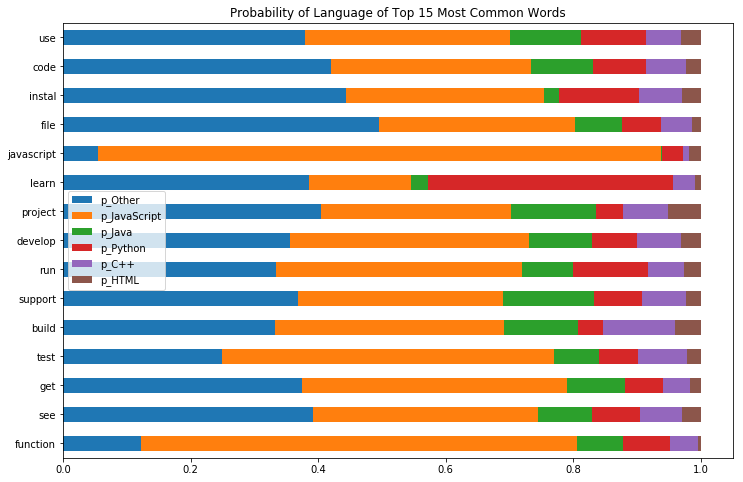

In [111]:
lang_prob = top_words[["all"]].copy()
for lang in top_words.drop(columns="all"):
    lang_prob[f"p_{lang}"] = top_words[lang] / top_words["all"]

lang_prob.sort_values(by="all").tail(15).drop(columns="all").plot.barh(
    stacked=True, figsize=(12, 8)
)
plt.title("Probability of Language of Top 15 Most Common Words")
plt.show()

Unsurprisingly, the most common words are representatively spread out among the categories

#### Word Cloud

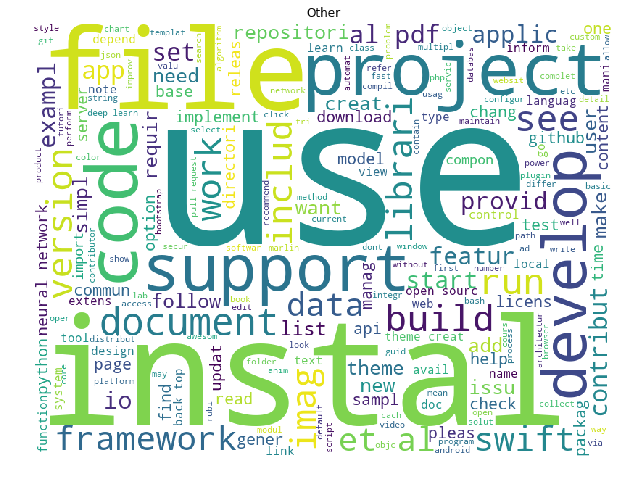

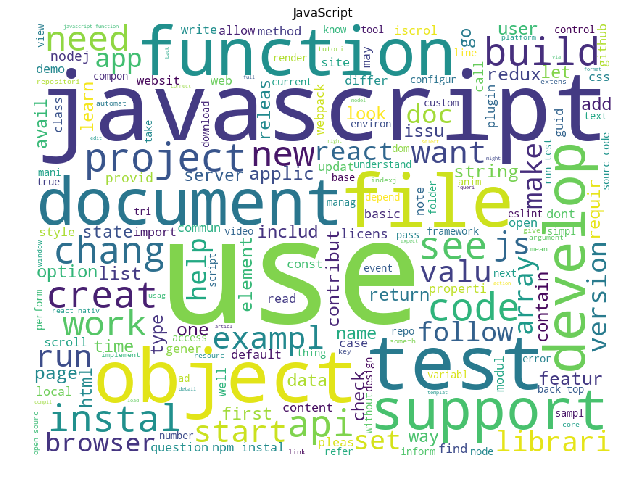

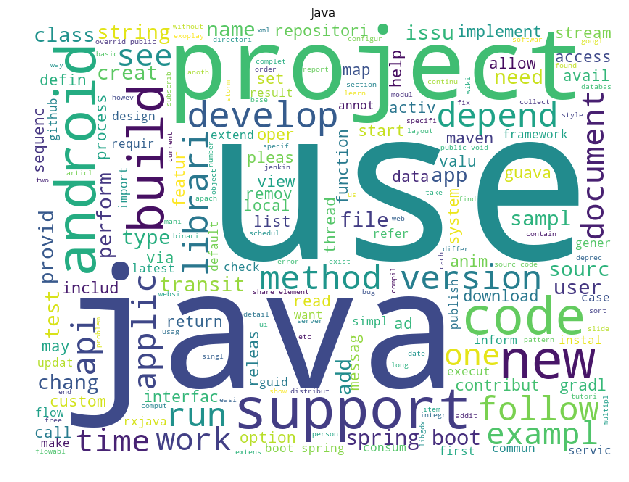

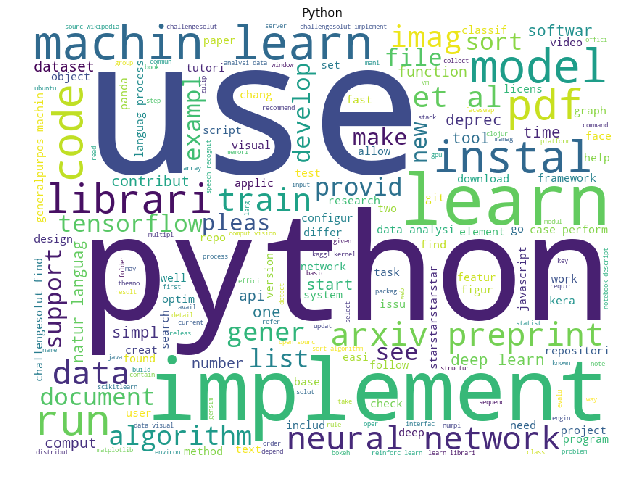

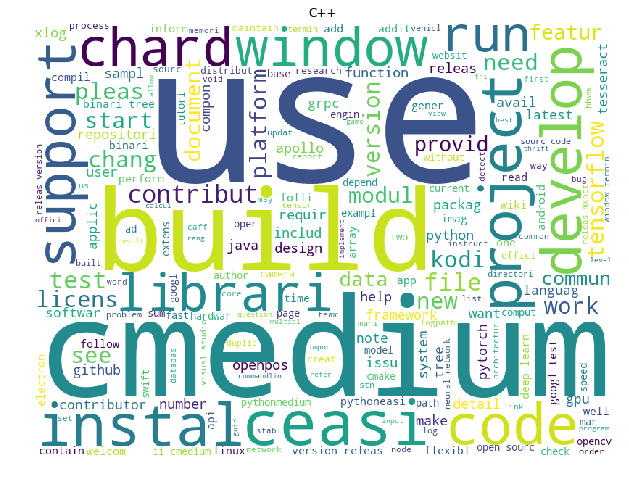

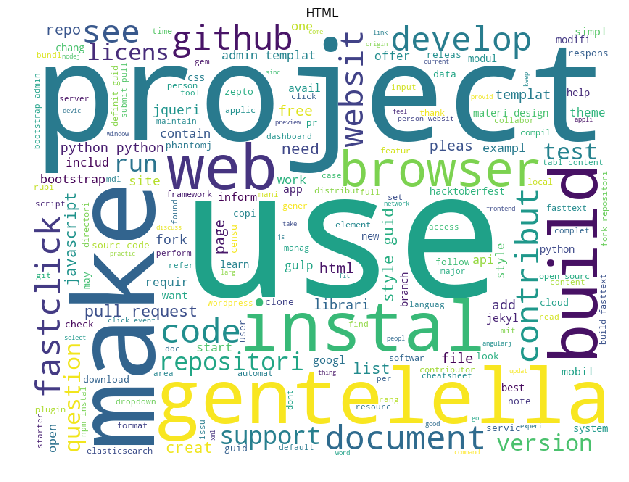

In [34]:
for lang, words in words_by_lang.items():
    plt.figure(figsize=(12, 8))
    cloud = WordCloud(
        background_color="white", height=600, width=800
    ).generate(words)
    plt.title(lang)
    plt.axis("off")
    plt.imshow(cloud)

**Conclusions**

"project", "use' are common words among the languages, but other than these, the most common words among the languages are different.

### Bigrams

**Most common bigrams and bar plot**

Other
(al, pdf)            165
(et, al)             165
(neural, network)    106
(open, sourc)         89
(theme, creat)        85
dtype: int64


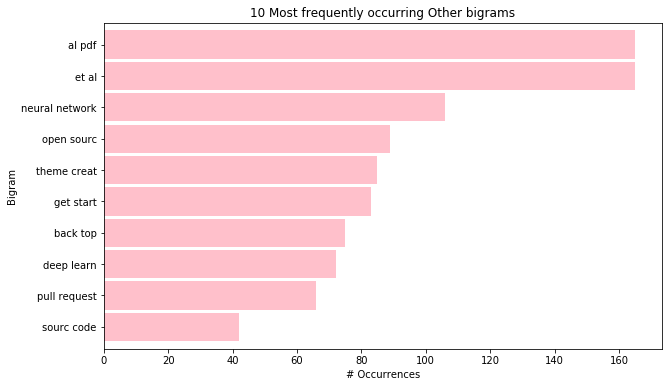

JavaScript
(get, start)     102
(npm, instal)     81
(back, top)       60
(sourc, code)     52
(run, test)       52
dtype: int64


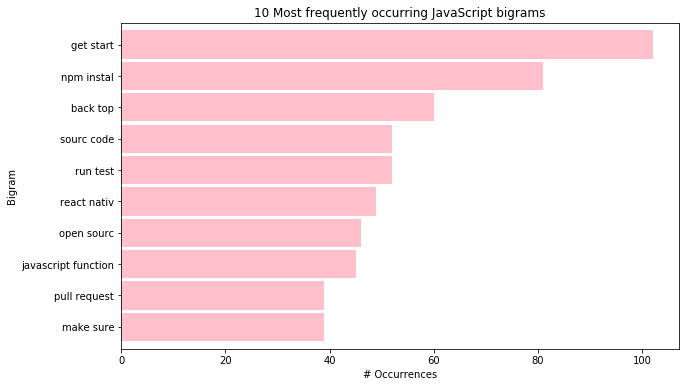

Java
(spring, boot)       52
(boot, spring)       24
(overrid, public)    23
(public, void)       21
(sourc, code)        19
dtype: int64


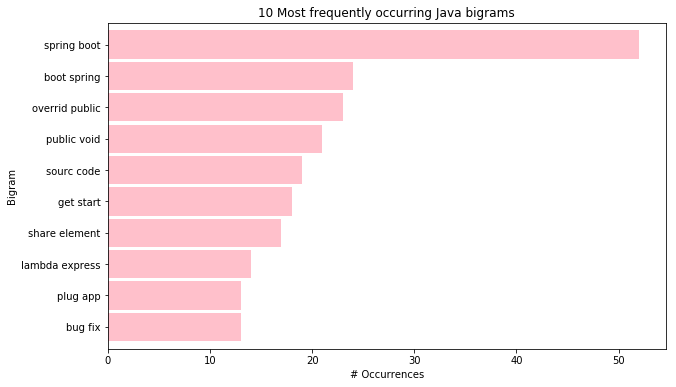

Python
(machin, learn)      112
(arxiv, preprint)     80
(neural, network)     79
(et, al)              65
(deep, learn)         45
dtype: int64


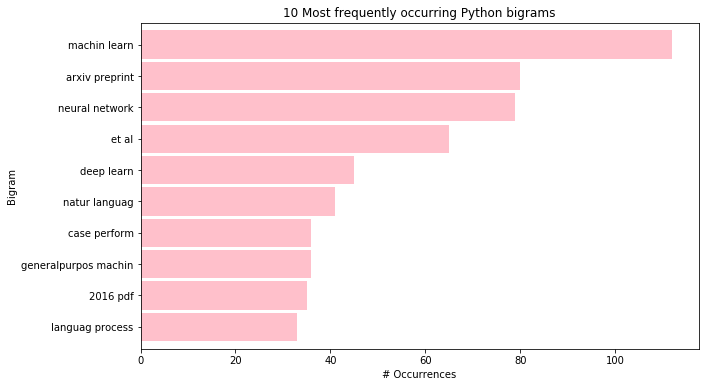

C++
(binari, tree)    17
(deep, learn)     16
(googl, test)     16
(ii, cmedium)     14
(open, sourc)     14
dtype: int64


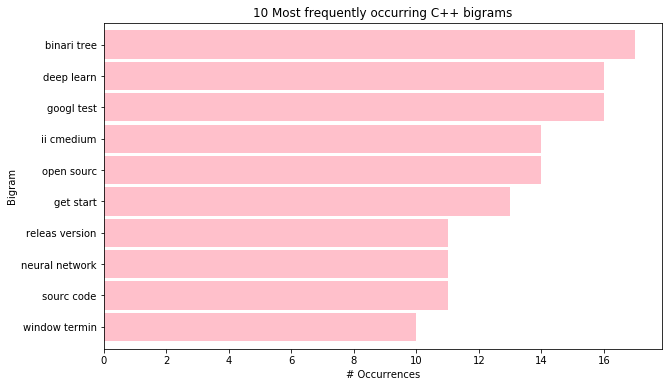

HTML
(pull, request)     16
(style, guid)       15
(python, python)    11
(admin, templat)    11
(materi, design)     8
dtype: int64


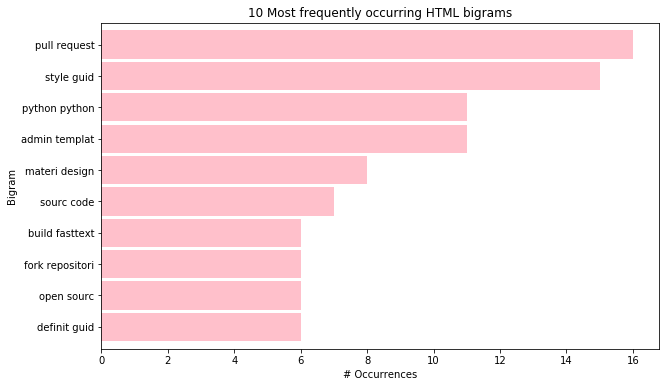

In [35]:
for lang, words in words_by_lang.items():
    bigrams = pd.Series(nltk.ngrams(words.split(), 2)).value_counts()
    print(f"{lang}\n{bigrams.head()}")

    # Bar plot the bigrams
    bigrams.sort_values().tail(10).plot.barh(
        color="pink", width=0.9, figsize=(10, 6)
    )

    plt.title(f"10 Most frequently occurring {lang} bigrams")
    plt.ylabel("Bigram")
    plt.xlabel("# Occurrences")

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = (
        bigrams.sort_values()
        .tail(10)
        .reset_index()["index"]
        .apply(lambda t: " ".join(t))
    )
    _ = plt.yticks(ticks, labels)
    plt.show()

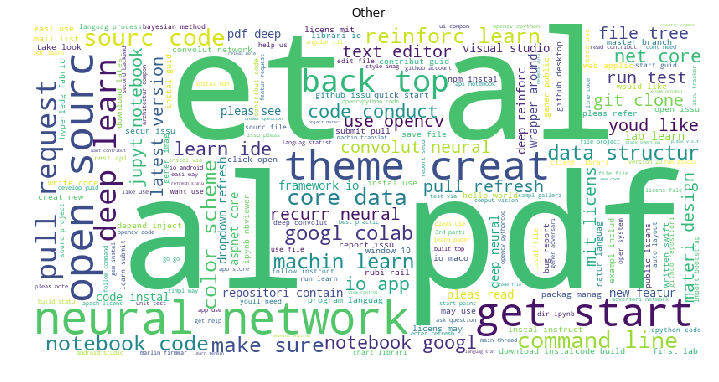

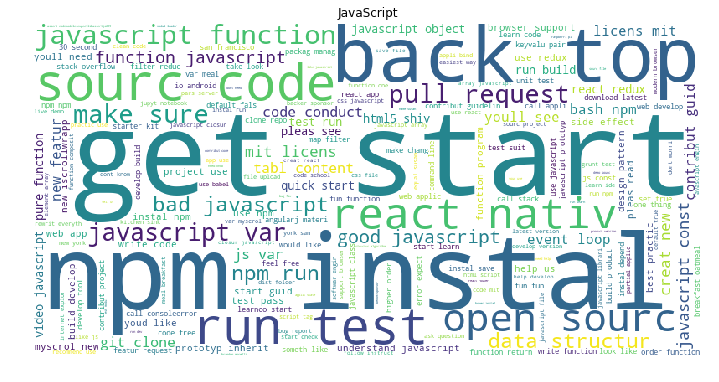

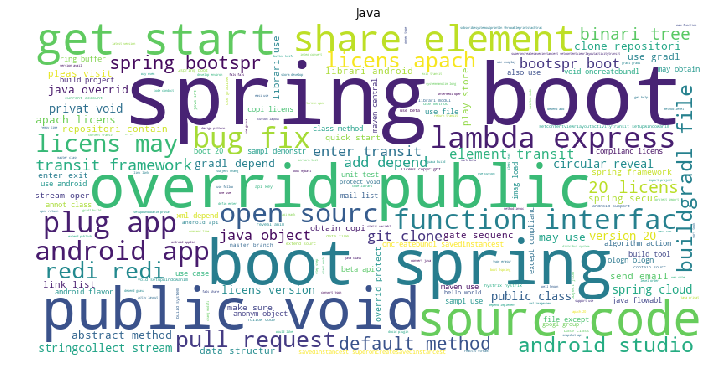

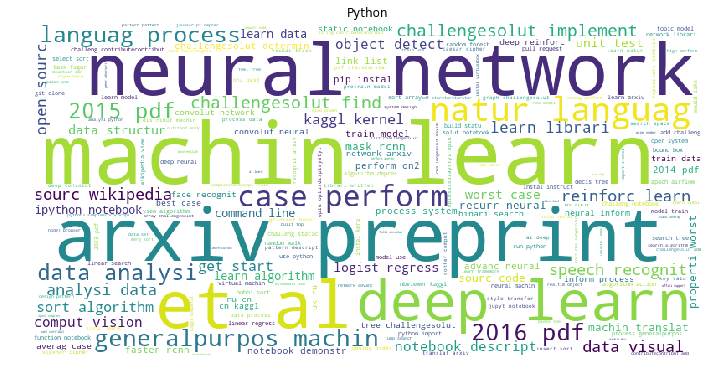

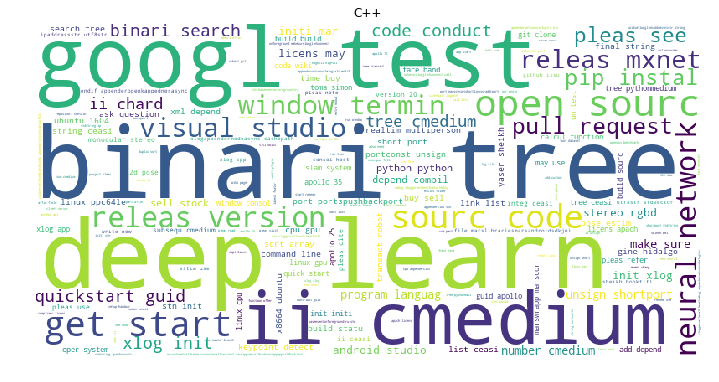

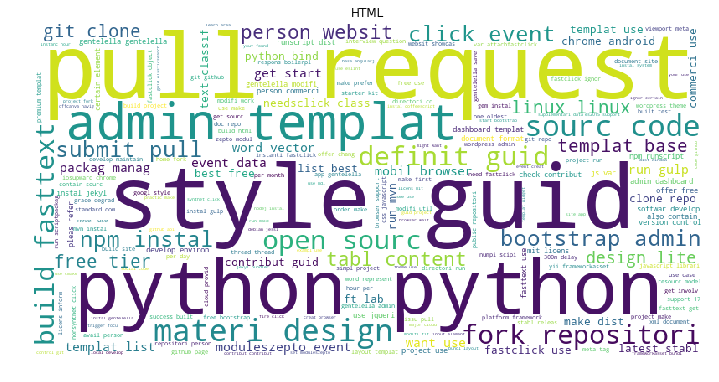

In [36]:
for lang, words in words_by_lang.items():
    bigrams = pd.Series(nltk.ngrams(words.split(), 2)).value_counts()

    # word cloud
    data = {" ".join(k): v for k, v in bigrams.to_dict().items()}
    img = WordCloud(
        background_color="white", width=800, height=400
    ).generate_from_frequencies(data)
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.title(lang)
    plt.imshow(img)

**Conclusions**

There is overlap among the languages as to the most common bigrams. The brigrams may not be that helpful after all.

### Trigram

Other
(et, al, pdf)                  160
(notebook, googl, colab)        27
(convolut, neural, network)     24
(recurr, neural, network)       21
(deep, neural, network)         18
dtype: int64


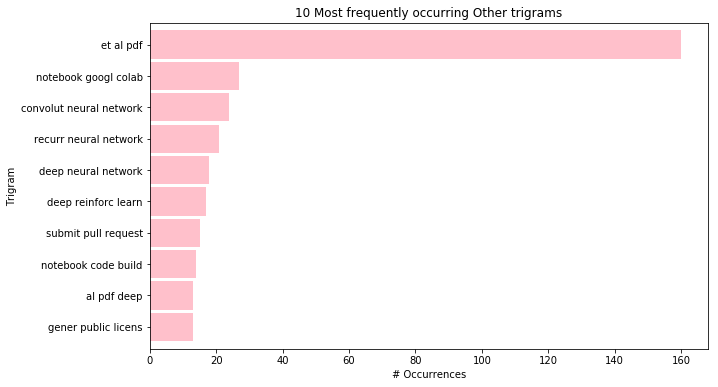

JavaScript
(bash, npm, instal)             15
(good, javascript, function)    14
(myscrol, new, iscrollwrapp)    14
(fun, fun, function)            13
(get, start, guid)              13
dtype: int64


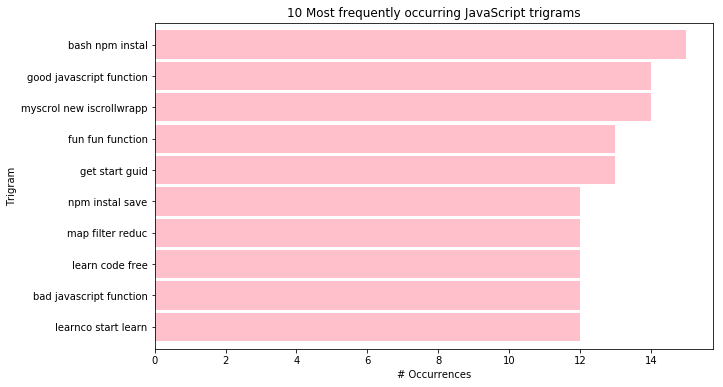

Java
(spring, boot, spring)       20
(overrid, public, void)      20
(boot, spring, boot)         14
(spring, bootspr, boot)       9
(share, element, transit)     8
dtype: int64


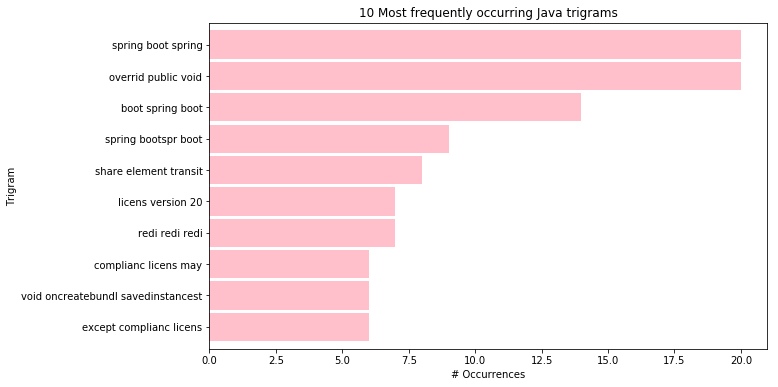

Python
(generalpurpos, machin, learn)    34
(natur, languag, process)         33
(data, analysi, data)             19
(analysi, data, visual)           18
(properti, worst, case)           12
dtype: int64


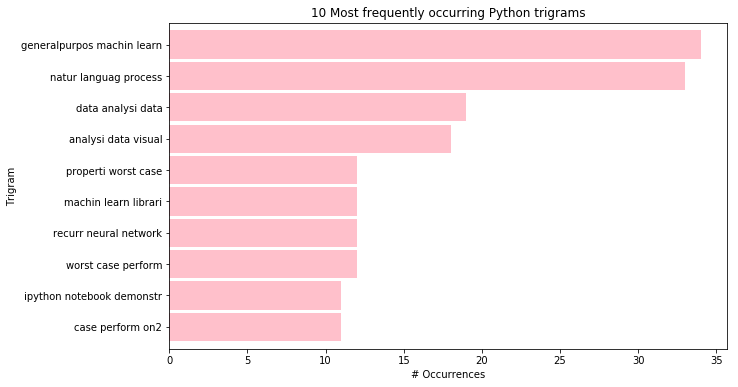

C++
(portconst, unsign, shortport)    6
(time, buy, sell)                 6
(xml, depend, compil)             6
(buy, sell, stock)                6
(binari, search, tree)            5
dtype: int64


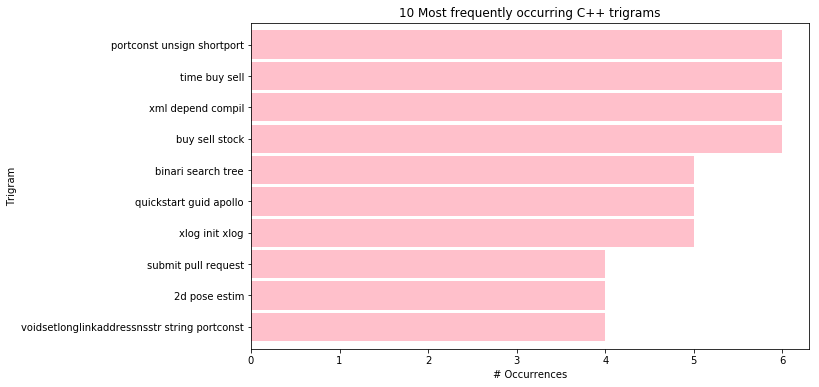

HTML
(python, python, python)       7
(submit, pull, request)        5
(moduleszepto, event, data)    4
(bootstrap, admin, templat)    4
(materi, design, lite)         4
dtype: int64


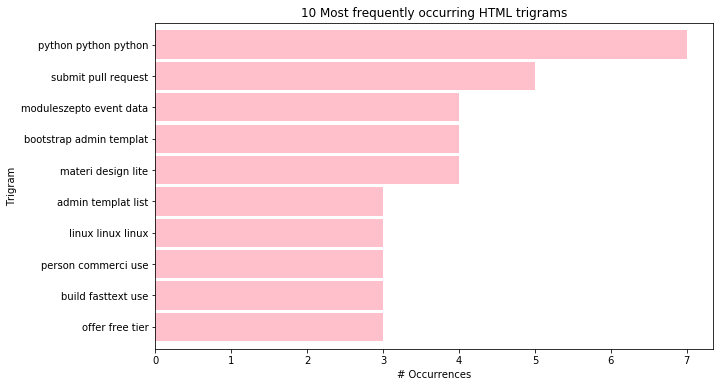

In [37]:
for lang, words in words_by_lang.items():
    trigrams = pd.Series(nltk.ngrams(words.split(), 3)).value_counts()
    print(f"{lang}\n{trigrams.head()}")

    # Bar plot the trigrams
    trigrams.sort_values().tail(10).plot.barh(
        color="pink", width=0.9, figsize=(10, 6)
    )

    plt.title(f"10 Most frequently occurring {lang} trigrams")
    plt.ylabel("Trigram")
    plt.xlabel("# Occurrences")

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = (
        trigrams.sort_values()
        .tail(10)
        .reset_index()["index"]
        .apply(lambda t: " ".join(t))
    )
    _ = plt.yticks(ticks, labels)
    plt.show()

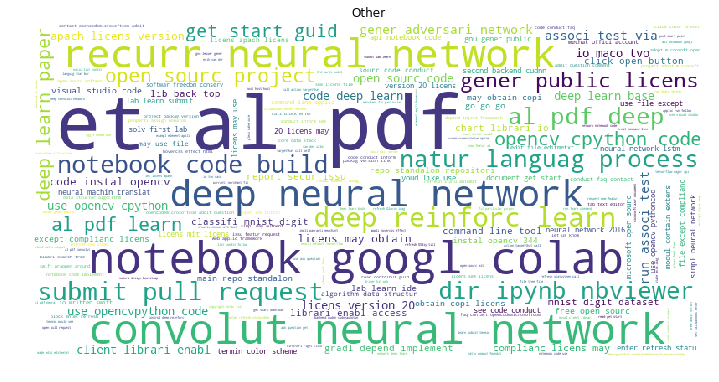

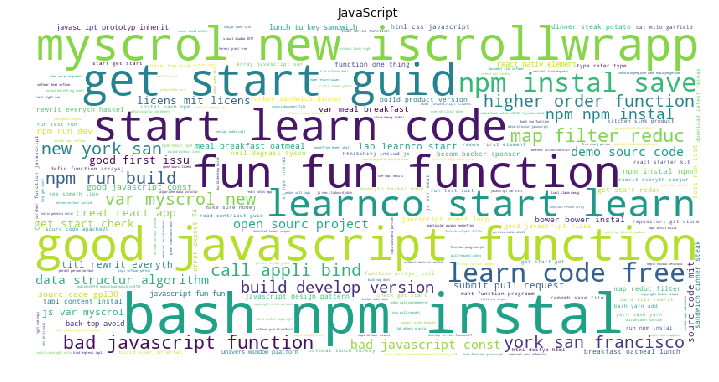

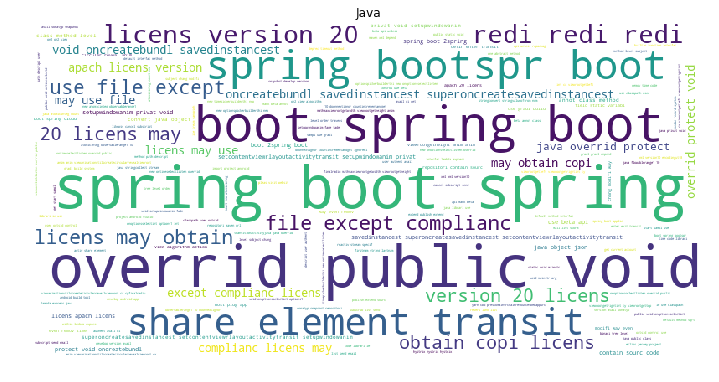

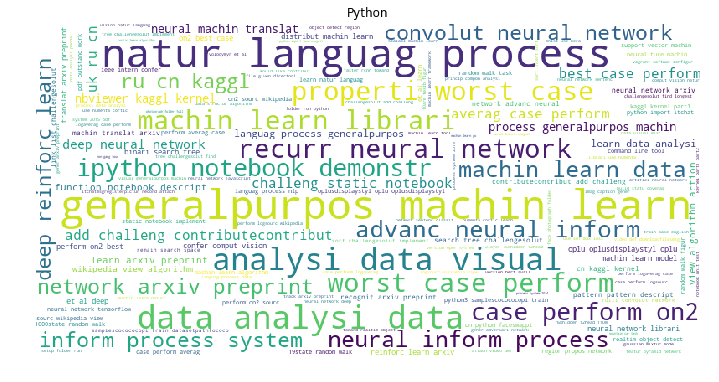

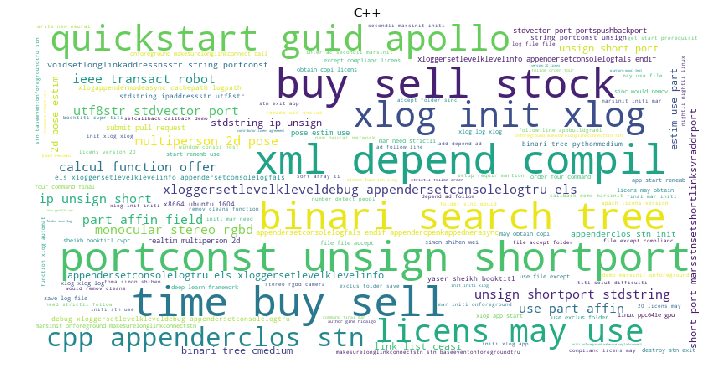

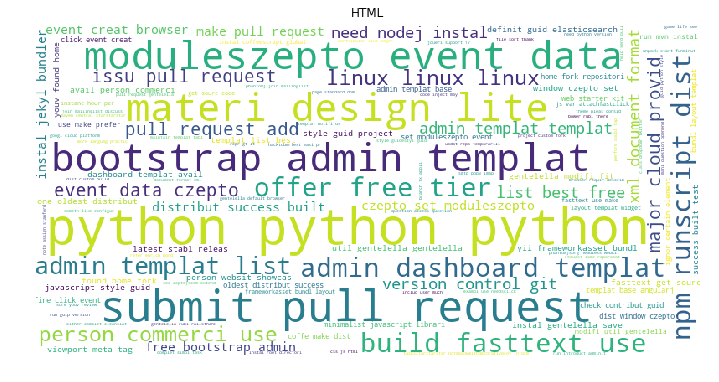

In [38]:
for lang, words in words_by_lang.items():
    trigrams = pd.Series(nltk.ngrams(words.split(), 3)).value_counts()

    # word cloud
    data = {" ".join(k): v for k, v in trigrams.to_dict().items()}
    img = WordCloud(
        background_color="white", width=800, height=400
    ).generate_from_frequencies(data)
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.title(lang)
    plt.imshow(img)

**Conclusion**


While there is less overlap of the most common trigrams than bigrams, these appear to be mostly junk or unique to a specific repo. 

### Summarize Conclusions

## Modeling <a name="modeling"></a>

In [39]:
def confmatrix(y_actual, y_pred):
    df = pd.DataFrame(dict(actual=y_actual, predicted=y_pred))
    return pd.crosstab(df.predicted, df.actual)

### Train test split

In [40]:
print("before removal", len(df))
df = df[df.lang_grouped.isin(top_five)]
print("after removal", len(df))

before removal 780
after removal 490


In [41]:
df.lang_grouped.value_counts()

JavaScript    221
Java          115
Python         76
C++            43
HTML           35
Name: lang_grouped, dtype: int64

**Clean gives better results than lemmatized or stemmed**

In [42]:
# X_train, X_test, y_train, y_test = train_test_split(
#     df.lemmatized, df.lang_grouped, stratify=df.lang_grouped, test_size=0.2, random_state=123
# )

# X_train, X_test, y_train, y_test = train_test_split(
#     df.stemmed, df.lang_grouped, stratify=df.lang_grouped, test_size=0.2, random_state=123
# )

X_train, X_test, y_train, y_test = train_test_split(
    df.clean, df.lang_grouped, stratify=df.lang_grouped, test_size=0.2, random_state=123
)

In [43]:
X_train.shape

(392,)

In [44]:
X_train.head()

759    start bootstrap library open source free downl...
720    ccxt cryptocurrency exchange trading library j...
392    detectron detectron facebook ai researchs soft...
506    spring mvc showcase demonstrates capabilities ...
187    extreme gradient boosting community documentat...
Name: clean, dtype: object

In [45]:
type(X_train)

pandas.core.series.Series

### For ALL Words

### Calculate TF-IDF for each word

In [46]:
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [47]:
train_tfidf.shape

(392, 17364)

**Words with highest tf-idf**

In [48]:
df_tfidf.max().sort_values(ascending=False).head(10)

amp         0.894030
zulip       0.890538
phonegap    0.882509
gekko       0.872370
bokeh       0.866685
redux       0.866378
pixijs      0.853271
edx         0.852861
v8          0.846757
brackets    0.841404
dtype: float64

**Words with lowest tf-idf**

In [49]:
df_tfidf.max().sort_values(ascending=False).tail(10)

olivier            0.005218
appendto           0.005218
toby               0.005218
oleksii            0.005218
devan              0.005218
eigenjavascript    0.005218
intervals          0.004957
rob                0.004919
grasp              0.004919
preventing         0.004919
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


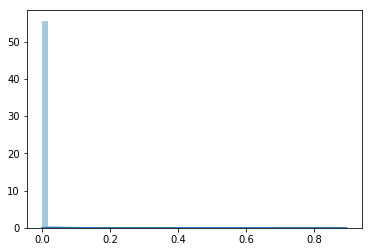

In [50]:
sns.distplot(train_tfidf.todense().flatten())

### KNN

In [51]:
def knnmodel(X_train, X_test, y_train, y_test, **kwargs):
    ks = range(1, 15)
    sse = []
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_train)

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_)

    print(pd.DataFrame(dict(k=ks, sse=sse)))

    plt.plot(ks, sse, "bx-")
    plt.xlabel("k")
    plt.ylabel("SSE")
    plt.title("The Elbow Method showing the optimal k")
    plt.show()
    
    knn = KNeighborsClassifier(**kwargs)
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_proba_train = knn.predict_proba(X_train)
    
    print("TRAIN")
    print()
    print(
        "Accuracy of KNN classifier on training set: {:.2f}".format(
        knn.score(X_train, y_train)
        )
    )
    print()
    confmatrix(y_train, y_pred_train)
    print()
    print(classification_report(y_train, y_pred_train))
    
    y_pred_test = knn.predict(X_test)
    y_pred_proba_test = knn.predict_proba(X_test)
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    print(
        "Accuracy of KNN classifier on training set: {:.2f}".format(
        knn.score(X_test, y_test)
        )
    )
    print()
    confmatrix(y_test, y_pred_test)
    print()
    print(classification_report(y_test, y_pred_test))
    
    k_range = range(1, 20)
    scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
    plt.figure()
    plt.xlabel("k")
    plt.ylabel("accuracy")
    plt.scatter(k_range, scores)
    # plt.xticks([0,5,10,15,20])
    
    return knn

     k         sse
0    1  382.661562
1    2  380.132875
2    3  378.705271
3    4  376.841002
4    5  374.857895
5    6  373.435542
6    7  372.285029
7    8  370.330026
8    9  367.997714
9   10  366.937234
10  11  365.517792
11  12  364.125567
12  13  363.287378
13  14  361.813274


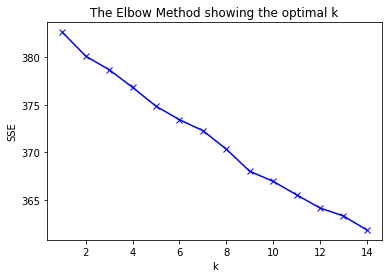

TRAIN

Accuracy of KNN classifier on training set: 0.76


              precision    recall  f1-score   support

         C++       0.82      0.41      0.55        34
        HTML       0.64      0.32      0.43        28
        Java       0.72      0.80      0.76        92
  JavaScript       0.77      0.90      0.83       177
      Python       0.80      0.67      0.73        61

   micro avg       0.76      0.76      0.76       392
   macro avg       0.75      0.62      0.66       392
weighted avg       0.76      0.76      0.75       392

--------------------

TEST

Accuracy of KNN classifier on training set: 0.74


              precision    recall  f1-score   support

         C++       0.50      0.11      0.18         9
        HTML       0.67      0.29      0.40         7
        Java       0.73      0.83      0.78        23
  JavaScript       0.77      0.93      0.85        44
      Python       0.71      0.67      0.69        15

   micro avg       0.74      0.74      0.74     

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=19, p=2,
           weights='uniform')

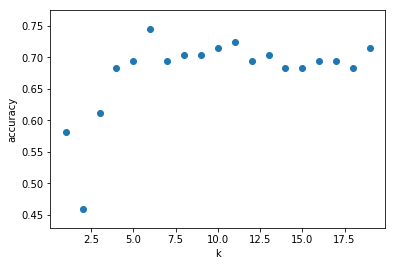

In [52]:
knnmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_neighbors=6, weights="uniform")

### Naive Bayes Model

In [ ]:
def nbmodel(X_train, X_test, y_train, y_test, **kwargs):
    gnb = GaussianNB(**kwargs)
    gnb.fit(X_train, y_train)
    
    print("TRAIN")
    print()
    y_pred_train = gnb.predict(X_train)
    print(
        "Accuracy of GNB classifier on training set: {:.2f}".format(
            gnb.score(X_train, y_train)
        )
    )
    print()
    print(confmatrix(y_train, y_pred_train))
    print()
    print(classification_report(y_train, y_pred_train))
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    y_pred_test = gnb.predict(X_test)
    print(
        "Accuracy of GNB classifier on training set: {:.2f}".format(
            gnb.score(X_test, y_test)
        )
    )
    print()
    print(confmatrix(y_test, y_pred_test))
    print()
    print(classification_report(y_test, y_pred_test))
    
    return gnb

In [109]:
nbmodel(train_tfidf.todense(), test_tfidf.todense(), y_train, y_test)

TRAIN

Accuracy of GNB classifier on training set: 0.94

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          32     1     1           9       5
HTML          0    26     0           2       0
Java          1     1    90           1       0
JavaScript    0     0     1         165       1
Python        1     0     0           0      55

              precision    recall  f1-score   support

         C++       0.67      0.94      0.78        34
        HTML       0.93      0.93      0.93        28
        Java       0.97      0.98      0.97        92
  JavaScript       0.99      0.93      0.96       177
      Python       0.98      0.90      0.94        61

   micro avg       0.94      0.94      0.94       392
   macro avg       0.91      0.94      0.92       392
weighted avg       0.95      0.94      0.94       392

--------------------

TEST

Accuracy of GNB classifier on training set: 0.61

actual      C++  HTML  Java  JavaScript

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

### Logistic Regression

In [55]:
def lrmodel(X_train, X_test, y_train, y_test, **kwargs):
    lm = LogisticRegression(**kwargs).fit(X_train, y_train)
    
    print("TRAIN")
    print()
    y_pred_train = lm.predict(X_train)
    print(
        "Accuracy of lm classifier on training set: {:.2f}".format(
            accuracy_score(y_train, y_pred_train)
        )
    )
    print()
    print(confmatrix(y_train, y_pred_train))
    print()
    print(classification_report(y_train, y_pred_train))
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    y_pred_test = lm.predict(X_test)
    print(
        "Accuracy of lm classifier on training set: {:.2f}".format(
            accuracy_score(y_test, y_pred_test)
        )
    )
    print()
    print(confmatrix(y_test, y_pred_test))
    print()
    print(classification_report(y_test, y_pred_test))
    
    return lm

In [56]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           0       0
HTML          0    28     0           0       0
Java          0     0    92           2       0
JavaScript    0     0     0         175       0
Python        0     0     0           0      61

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        34
        HTML       1.00      1.00      1.00        28
        Java       0.98      1.00      0.99        92
  JavaScript       1.00      0.99      0.99       177
      Python       1.00      1.00      1.00        61

   micro avg       0.99      0.99      0.99       392
   macro avg       1.00      1.00      1.00       392
weighted avg       1.00      0.99      0.99       392

--------------------

TEST

Accuracy of lm classifier on training set: 0.71

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

### Decision Tree

In [57]:
clf = DecisionTreeClassifier(
    criterion="entropy", max_depth=20, random_state=123, class_weight="balanced"
)

In [58]:
clf.fit(train_tfidf, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [59]:
y_pred = clf.predict(train_tfidf)
y_pred[0:5]

array(['HTML', 'JavaScript', 'Python', 'Java', 'C++'], dtype=object)

In [60]:
y_pred_proba = clf.predict_proba(train_tfidf)
# y_pred_proba

### Computing the accuracy of our model

In [61]:
print(
    "Accuracy of Decision Tree classifier on training set: {:.2f}".format(
        clf.score(train_tfidf, y_train)
    )
)

Accuracy of Decision Tree classifier on training set: 0.87


In [62]:
confmatrix(y_train, y_pred)

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           0       0
HTML          0    28     0           0       0
Java          0     0    80           0       0
JavaScript    0     0     0         138       0
Python        0     0    12          39      61

In [63]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        34
        HTML       1.00      1.00      1.00        28
        Java       1.00      0.87      0.93        92
  JavaScript       1.00      0.78      0.88       177
      Python       0.54      1.00      0.71        61

   micro avg       0.87      0.87      0.87       392
   macro avg       0.91      0.93      0.90       392
weighted avg       0.93      0.87      0.88       392



In [64]:
print(
    "Accuracy of Decision Tree classifier on test set: {:.2f}".format(
        clf.score(test_tfidf, y_test)
    )
)

Accuracy of Decision Tree classifier on test set: 0.46


### Random Forest

In [65]:
def rfmodel(X_train, X_test, y_train, y_test, **kwargs):
    clf = RandomForestClassifier(**kwargs).fit(X_train, y_train)
    
#     print("Feature Importances:")
#     print(clf.feature_importances_)
    print()
    print("TRAIN")
    print()
    y_pred_train = clf.predict(X_train)
    print(
        "Accuracy of clf classifier on training set: {:.2f}".format(
            accuracy_score(y_train, y_pred_train)
        )
    )
    print()
    print(confmatrix(y_train, y_pred_train))
    print()
    print(classification_report(y_train, y_pred_train))
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    y_pred_test = clf.predict(X_test)
    print(
        "Accuracy of clf classifier on training set: {:.2f}".format(
            accuracy_score(y_test, y_pred_test)
        )
    )
    print()
    print(confmatrix(y_test, y_pred_test))
    print()
    print(classification_report(y_test, y_pred_test))
    
    return clf

In [66]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=100,
    max_depth=10,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.92

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          28     0     0           0       0
HTML          0    25     0           0       0
Java          5     3    92          16       8
JavaScript    1     0     0         161       0
Python        0     0     0           0      53

              precision    recall  f1-score   support

         C++       1.00      0.82      0.90        34
        HTML       1.00      0.89      0.94        28
        Java       0.74      1.00      0.85        92
  JavaScript       0.99      0.91      0.95       177
      Python       1.00      0.87      0.93        61

   micro avg       0.92      0.92      0.92       392
   macro avg       0.95      0.90      0.92       392
weighted avg       0.94      0.92      0.92       392

--------------------

TEST

Accuracy of clf classifier on training set: 0.71

actual      C++  HTML  Java  JavaScrip

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

### Excluding frequent words

### Calculate TF-IDF for each word

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.05)
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [68]:
train_tfidf.shape

(392, 16892)

**Words with highest tf-idf**

In [69]:
df_tfidf.max().sort_values(ascending=False).head(10)

druid        1.000000
hadoop       1.000000
moved        1.000000
zookeeper    1.000000
head         1.000000
jennic       1.000000
docker       1.000000
tornado      1.000000
amp          0.949674
phonegap     0.945933
dtype: float64

**Words with lowest tf-idf**

In [70]:
df_tfidf.max().sort_values(ascending=False).tail(10)

303range             0.00532
98validate           0.00532
309best              0.00532
307range             0.00532
990satisfiability    0.00532
306additive          0.00532
991broken            0.00532
993cousins           0.00532
304range             0.00532
atoi                 0.00532
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


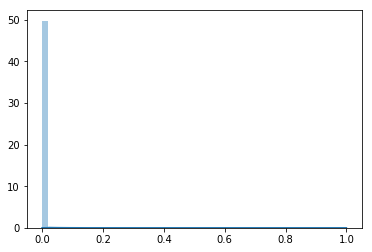

In [71]:
sns.distplot(train_tfidf.todense().flatten())

In [72]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           1       0
HTML          0    28     0           1       0
Java          0     0    92           1       0
JavaScript    0     0     0         174       0
Python        0     0     0           0      61

              precision    recall  f1-score   support

         C++       0.97      1.00      0.99        34
        HTML       0.97      1.00      0.98        28
        Java       0.99      1.00      0.99        92
  JavaScript       1.00      0.98      0.99       177
      Python       1.00      1.00      1.00        61

   micro avg       0.99      0.99      0.99       392
   macro avg       0.99      1.00      0.99       392
weighted avg       0.99      0.99      0.99       392

--------------------

TEST

Accuracy of lm classifier on training set: 0.64

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [73]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=1000,
    min_samples_leaf=3,
    max_depth=20,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.86

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          26     0     0           0       0
HTML          0    24     1           3       0
Java          5     3    91          25      11
JavaScript    2     0     0         149       1
Python        1     1     0           0      49

              precision    recall  f1-score   support

         C++       1.00      0.76      0.87        34
        HTML       0.86      0.86      0.86        28
        Java       0.67      0.99      0.80        92
  JavaScript       0.98      0.84      0.91       177
      Python       0.96      0.80      0.88        61

   micro avg       0.86      0.86      0.86       392
   macro avg       0.89      0.85      0.86       392
weighted avg       0.90      0.86      0.87       392

--------------------

TEST

Accuracy of clf classifier on training set: 0.66

actual      C++  HTML  Java  JavaScrip

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

### Excluding least frequent words

### Calculate TF-IDF for each word

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0.01)
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [75]:
with open("tfidf.obj", 'wb') as fp:
    pickle.dump(tfidf, fp)

In [76]:
train_tfidf.shape

(392, 2477)

**Words with highest tf-idf**

In [77]:
df_tfidf.max().sort_values(ascending=False).head(10)

cat         0.940624
redis       0.921336
redux       0.887850
brackets    0.869219
2015        0.867259
python3     0.863800
electron    0.860263
atom        0.857106
figure      0.855827
promise     0.827684
dtype: float64

**Words with lowest tf-idf**

In [78]:
df_tfidf.max().sort_values(ascending=False).tail(10)

imagine       0.028741
keeps         0.028401
anyway        0.028319
telling       0.028319
accomplish    0.027357
teaching      0.026543
mutable       0.023950
smallest      0.022502
absolute      0.018009
concept       0.012087
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


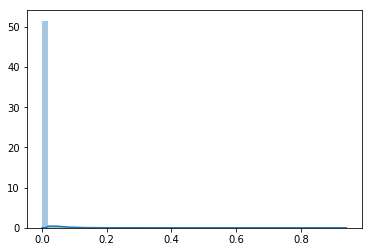

In [79]:
sns.distplot(train_tfidf.todense().flatten())

In [80]:
lm = lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.97

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          33     0     1           0       0
HTML          0    28     0           3       0
Java          1     0    91           5       0
JavaScript    0     0     0         167       0
Python        0     0     0           2      61

              precision    recall  f1-score   support

         C++       0.97      0.97      0.97        34
        HTML       0.90      1.00      0.95        28
        Java       0.94      0.99      0.96        92
  JavaScript       1.00      0.94      0.97       177
      Python       0.97      1.00      0.98        61

   micro avg       0.97      0.97      0.97       392
   macro avg       0.96      0.98      0.97       392
weighted avg       0.97      0.97      0.97       392

--------------------

TEST

Accuracy of lm classifier on training set: 0.70

actual      C++  HTML  Java  JavaScript  

# Best Model

#### Save It

In [81]:
with open("lrmodel.obj", 'wb') as fp:
    pickle.dump(lm, fp)

In [82]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=1000,
    min_samples_leaf=3,
    max_depth=20,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.94

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          33     0     0           0       0
HTML          0    26     0           0       0
Java          1     1    92          17       3
JavaScript    0     0     0         160       0
Python        0     1     0           0      58

              precision    recall  f1-score   support

         C++       1.00      0.97      0.99        34
        HTML       1.00      0.93      0.96        28
        Java       0.81      1.00      0.89        92
  JavaScript       1.00      0.90      0.95       177
      Python       0.98      0.95      0.97        61

   micro avg       0.94      0.94      0.94       392
   macro avg       0.96      0.95      0.95       392
weighted avg       0.95      0.94      0.94       392

--------------------

TEST

Accuracy of clf classifier on training set: 0.68

actual      C++  HTML  Java  JavaScrip

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

### Excluding most and least frequent words

### Calculate TF-IDF for each word

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0.01, max_df=0.05)
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [84]:
train_tfidf.shape

(392, 2005)

**Words with highest tf-idf**

In [85]:
df_tfidf.max().sort_values(ascending=False).head(10)

docker        1.0
pattern       1.0
2015          1.0
posts         1.0
python3       1.0
moved         1.0
exercise      1.0
renamed       1.0
middleware    1.0
head          1.0
dtype: float64

**Words with lowest tf-idf**

In [86]:
df_tfidf.max().sort_values(ascending=False).tail(10)

teaching       0.040938
keeps          0.040526
32             0.040328
declaration    0.039148
31             0.038958
combine        0.037190
mutable        0.035245
smallest       0.030505
absolute       0.019217
concept        0.017204
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


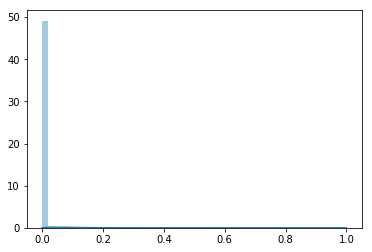

In [87]:
sns.distplot(train_tfidf.todense().flatten())

In [88]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.96

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          33     0     0           1       0
HTML          0    28     2           2       0
Java          0     0    87           3       0
JavaScript    1     0     3         171       2
Python        0     0     0           0      59

              precision    recall  f1-score   support

         C++       0.97      0.97      0.97        34
        HTML       0.88      1.00      0.93        28
        Java       0.97      0.95      0.96        92
  JavaScript       0.97      0.97      0.97       177
      Python       1.00      0.97      0.98        61

   micro avg       0.96      0.96      0.96       392
   macro avg       0.96      0.97      0.96       392
weighted avg       0.97      0.96      0.96       392

--------------------

TEST

Accuracy of lm classifier on training set: 0.66

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [89]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=100,
    max_depth=20,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.92

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          30     0     0           0       0
HTML          0    27     0           0       0
Java          0     0    79           0       1
JavaScript    4     1    13         177      12
Python        0     0     0           0      48

              precision    recall  f1-score   support

         C++       1.00      0.88      0.94        34
        HTML       1.00      0.96      0.98        28
        Java       0.99      0.86      0.92        92
  JavaScript       0.86      1.00      0.92       177
      Python       1.00      0.79      0.88        61

   micro avg       0.92      0.92      0.92       392
   macro avg       0.97      0.90      0.93       392
weighted avg       0.93      0.92      0.92       392

--------------------

TEST

Accuracy of clf classifier on training set: 0.64

actual      C++  HTML  Java  JavaScrip

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

**Conclusions**

Results are very mixed when excluding the most and/or least frequent words. Sometimes the results of the model improve and sometimes they get worse.

### Using Bigrams as features

### TF-IDF

In [90]:
TOP_NBIGRAMS = 5_000
# top_nwords = top_words.sort_values(by="all", ascending=False).head(500)
# top_nwords.index.values

### Calculate TF-IDF for each word

In [91]:
tfidf = TfidfVectorizer(
    strip_accents="unicode", max_features=TOP_NBIGRAMS, ngram_range=(2, 2)
)
# tfidf = TfidfVectorizer(
#     strip_accents="unicode", ngram_range=(2, 2)
# )
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [92]:
train_tfidf.shape

(392, 5000)

In [93]:
test_tfidf.shape

(98, 5000)

In [94]:
df_tfidf.max().sort_values(ascending=False).head(10)

build status            1.0
documentation source    1.0
git clone               1.0
tutorial beginners      1.0
web server              1.0
full documentation      1.0
operating system        1.0
license mit             1.0
documentation site      1.0
javascript event        1.0
dtype: float64

In [95]:
df_tfidf.max().sort_values(ascending=False).tail(10)

first paper                 0.017366
international publishing    0.017366
systems 2013                0.017366
object tracking             0.017366
processing ieee             0.017366
batch normalization         0.017366
pattern recognition         0.016245
change every                0.013711
filter javascript           0.011253
data neural                 0.009171
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


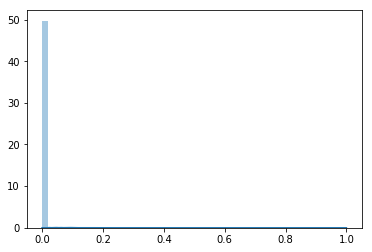

In [96]:
sns.distplot(train_tfidf.todense().flatten())

### Naive Bayes Model

In [97]:
nbmodel(train_tfidf.todense(), test_tfidf.todense(), y_train, y_test)

TRAIN

Accuracy of GNB classifier on training set: 0.92

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          32     0     1           1       0
HTML          2    28     4          12       8
Java          0     0    85           1       0
JavaScript    0     0     0         162       0
Python        0     0     2           1      53

              precision    recall  f1-score   support

         C++       0.94      0.94      0.94        34
        HTML       0.52      1.00      0.68        28
        Java       0.99      0.92      0.96        92
  JavaScript       1.00      0.92      0.96       177
      Python       0.95      0.87      0.91        61

   micro avg       0.92      0.92      0.92       392
   macro avg       0.88      0.93      0.89       392
weighted avg       0.95      0.92      0.93       392

--------------------

TEST

Accuracy of GNB classifier on training set: 0.59

actual      C++  HTML  Java  JavaScript

GaussianNB(priors=None, var_smoothing=1e-09)

### Logistic Regression

In [98]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test,
    random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced",
)

TRAIN

Accuracy of lm classifier on training set: 0.97

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          33     0     0           0       0
HTML          0    27     0           1       0
Java          0     0    90           1       0
JavaScript    1     1     2         175       5
Python        0     0     0           0      56

              precision    recall  f1-score   support

         C++       1.00      0.97      0.99        34
        HTML       0.96      0.96      0.96        28
        Java       0.99      0.98      0.98        92
  JavaScript       0.95      0.99      0.97       177
      Python       1.00      0.92      0.96        61

   micro avg       0.97      0.97      0.97       392
   macro avg       0.98      0.96      0.97       392
weighted avg       0.97      0.97      0.97       392

--------------------

TEST

Accuracy of lm classifier on training set: 0.59

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

### Random Forest

In [99]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=100, max_depth=20, random_state=123, class_weight="balanced"
)


TRAIN

Accuracy of clf classifier on training set: 0.82

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          27     0     0           0       0
HTML          0    24     0           0       0
Java          6     4    91          42      16
JavaScript    0     0     1         135       0
Python        1     0     0           0      45

              precision    recall  f1-score   support

         C++       1.00      0.79      0.89        34
        HTML       1.00      0.86      0.92        28
        Java       0.57      0.99      0.73        92
  JavaScript       0.99      0.76      0.86       177
      Python       0.98      0.74      0.84        61

   micro avg       0.82      0.82      0.82       392
   macro avg       0.91      0.83      0.85       392
weighted avg       0.89      0.82      0.83       392

--------------------

TEST

Accuracy of clf classifier on training set: 0.53

actual      C++  HTML  Java  JavaScrip

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

### Bag of Words

In [100]:
vectorizer = CountVectorizer(max_features=750)
train_bow = vectorizer.fit_transform(X_train)
test_bow = vectorizer.transform(X_test)

df_bow = pd.DataFrame(train_bow.todense(), columns=vectorizer.get_feature_names())

In [101]:
train_bow.shape

(392, 750)

**Most common wordsf**

In [102]:
df_bow.sum().sort_values(ascending=False).head(10)

javascript    715
use           599
code          494
using         434
new           360
data          344
see           333
project       328
install       300
learning      290
dtype: int64

**Least common words**

In [103]:
df_bow.sum().sort_values(ascending=False).tail(10)

changed        24
setting        24
scale          24
lightweight    24
focus          24
bar            23
faq            23
convert        23
soon           23
slide          23
dtype: int64

In [104]:
nbmodel(train_bow.todense(), test_bow.todense(), y_train, y_test)

TRAIN

Accuracy of GNB classifier on training set: 0.75

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          32     0    17          11      12
HTML          2    28     7          14       5
Java          0     0    68          20       6
JavaScript    0     0     0         128       0
Python        0     0     0           4      38

              precision    recall  f1-score   support

         C++       0.44      0.94      0.60        34
        HTML       0.50      1.00      0.67        28
        Java       0.72      0.74      0.73        92
  JavaScript       1.00      0.72      0.84       177
      Python       0.90      0.62      0.74        61

   micro avg       0.75      0.75      0.75       392
   macro avg       0.71      0.81      0.72       392
weighted avg       0.84      0.75      0.77       392

--------------------

TEST

Accuracy of GNB classifier on training set: 0.51

actual      C++  HTML  Java  JavaScript

GaussianNB(priors=None, var_smoothing=1e-09)

In [105]:
lrmodel(train_bow, test_bow, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           0       0
HTML          0    28     0           0       0
Java          0     0    91           1       0
JavaScript    0     0     0         175       0
Python        0     0     1           1      61

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        34
        HTML       1.00      1.00      1.00        28
        Java       0.99      0.99      0.99        92
  JavaScript       1.00      0.99      0.99       177
      Python       0.97      1.00      0.98        61

   micro avg       0.99      0.99      0.99       392
   macro avg       0.99      1.00      0.99       392
weighted avg       0.99      0.99      0.99       392

--------------------

TEST

Accuracy of lm classifier on training set: 0.60

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [106]:
rfmodel(train_bow, test_bow, y_train, y_test,
    n_estimators=200, max_depth=10, random_state=123, class_weight="balanced"
)


TRAIN

Accuracy of clf classifier on training set: 0.92

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          29     0     0           0       0
HTML          0    26     0           0       0
Java          4     2    92          20       6
JavaScript    1     0     0         157       0
Python        0     0     0           0      55

              precision    recall  f1-score   support

         C++       1.00      0.85      0.92        34
        HTML       1.00      0.93      0.96        28
        Java       0.74      1.00      0.85        92
  JavaScript       0.99      0.89      0.94       177
      Python       1.00      0.90      0.95        61

   micro avg       0.92      0.92      0.92       392
   macro avg       0.95      0.91      0.92       392
weighted avg       0.94      0.92      0.92       392

--------------------

TEST

Accuracy of clf classifier on training set: 0.67

actual      C++  HTML  Java  JavaScrip

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

**Conclusions**

For the most part, bag of words performs worse than TF-IDF, except for the random forest model.